# BERT

In [1]:
!pip install transformers

  Using cached transformers-4.17.0-py3-none-any.whl (3.8 MB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached tokenizers-0.11.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.5 MB)
  Using cached sacremoses-0.0.49-py3-none-any.whl (895 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install stanza

In [3]:
!pip install sklearn_crfsuite

In [4]:
!pip install -U 'scikit-learn<0.24'

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [5]:
! pip install natasha

  Using cached natasha-1.4.0-py3-none-any.whl (34.4 MB)
  Using cached ipymarkup-0.9.0-py3-none-any.whl (14 kB)
  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached slovnet-0.5.0-py3-none-any.whl (49 kB)
  Using cached razdel-0.5.0-py3-none-any.whl (21 kB)
  Using cached navec-0.10.0-py3-none-any.whl (23 kB)
  Using cached yargy-0.15.0-py3-none-any.whl (41 kB)
  Using cached intervaltree-3.1.0-py2.py3-none-any.whl
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [6]:
import os
import pandas as pd
import re
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import nltk
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

nltk.download('punkt')

import stanza
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_score
from collections import Counter
import seaborn as sns
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Загружаем модель

In [7]:
PRE_TRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [8]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

### Готовим данные

In [9]:
sents_data = pd.read_csv('sents_Wiki_tagged.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_data = sents_data.rename(columns = {'def' : 'has_def'}) 

In [10]:
shuffle =  sents_data.sample(frac=1).reset_index(drop=True) 

In [11]:
sents_data = shuffle[:700]
sents_data_test = shuffle[700:]

### Смотрим на данные

In [12]:
sents_data.head()

,Unnamed: 0,sent_index,sent_text,has_def
0,730,1051,Специализируется на решении практических задач...,0
1,776,1176,В этом случае участники попеременно выступают ...,0
2,782,1189,В разных языках число залогов различно; в неко...,0
3,419,18845,"Дирак, Поль — швейцарский и английский физик-т...",1
4,86,1367,"Паради́гма (от греч. παράδειγμα, «пример, моде...",1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


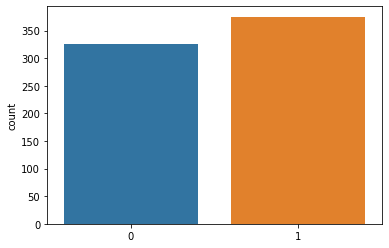

In [13]:
sns.countplot(list(sents_data['has_def']))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


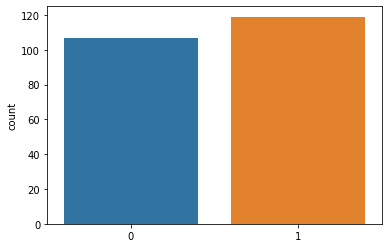

In [14]:
sns.countplot(list(sents_data_test['has_def']))

In [15]:
from statistics import mean
lens = [len(i) for i in list(sents_data['sent_text'])]
mean(lens)

172.7342857142857

### Датасет

In [16]:
class SentsDataset(Dataset):

  def __init__(self, sents, targets, tokenizer, max_len):
    self.sents = sents
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sents)
  
  def __getitem__(self, item):
    sent = str(self.sents[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sent,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sent_text':sent,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [17]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
df_train, df_test = train_test_split(sents_data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(sents_data_test, test_size=0.5, random_state=RANDOM_SEED)

In [19]:
MAX_LEN = 512

### DataLoader

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentsDataset(
    sents=df.sent_text.to_numpy(),
    targets=df.has_def.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [21]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sent_text', 'input_ids', 'attention_mask', 'targets'])

### Класс SentsClassifier

In [23]:
class SentsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentsClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    return output[0]

In [24]:
model = SentsClassifier(2)
model = model.to(device)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

### Обучаем

In [25]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.34637800413124925 accuracy 0.8777777777777778
Val loss 0.45930192694067956 accuracy 0.9557522123893805

Epoch 2/3
----------
Train loss 0.19944209652021527 accuracy 0.9444444444444444
Val loss 0.10712091770643989 accuracy 0.9646017699115044

Epoch 3/3
----------
Train loss 0.05701126295541224 accuracy 0.9857142857142858
Val loss 0.14766306321059045 accuracy 0.9469026548672567

CPU times: user 6min 23s, sys: 10.8 s, total: 6min 34s
Wall time: 6min 38s


### Смотрим метрики

In [29]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9292035398230089

Ура! Выглядит неплохо...

In [30]:
import torch.nn.functional as F

In [31]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sent_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sent_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sent_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sent_texts, predictions, prediction_probs, real_values

In [32]:
y_sent_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [33]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        55
           1       0.92      0.95      0.93        58

    accuracy                           0.93       113
   macro avg       0.93      0.93      0.93       113
weighted avg       0.93      0.93      0.93       113



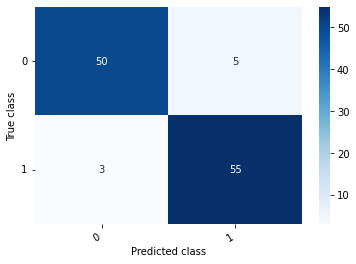

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
show_confusion_matrix(df_cm)

### Тестируем на каком-либо предложении

In [35]:
def predict(model, sentence):
    encoded_text = tokenizer.encode_plus(
        sentence,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True)
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    prediction = torch.argmax(output, dim=1)

    return prediction.cpu().numpy()[0]

In [36]:
predict(model, 'Лингвистика - это наука о языках, изучающая их как систему.')

1

# CRF

### Готовим файлы

In [37]:
df_sents = pd.read_csv('sents_Wiki_tagged.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_filtered = df_sents[df_sents['def'] > 0]
sents = list(sents_filtered['sent_text'])
ids = list(sents_filtered['sent_index'])

In [38]:
train_sents, dev_sents, train_ids, dev_ids = train_test_split(sents, ids)

In [39]:
df_tokens = pd.read_csv('tokens_Wiki_tagged.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_filtered = df_tokens[df_tokens['sent_index'].isin(ids)]
tokens = list(tokens_filtered['token'])
t_ids = list(tokens_filtered['sent_index'])

In [40]:
def bio_sents(sents_ids, tokens_df):
    bio_sents = {}
    for i in sents_ids:
        bio_sents[i] = list(tokens_df.loc[tokens_df['sent_index']==i]['tag'])
    return bio_sents

In [41]:
bio_sents_train = bio_sents(train_ids, df_tokens)
bio_sents_test = bio_sents(dev_ids, df_tokens)

In [42]:
def get_bert_ebm(word):
    encoding = tokenizer.encode_plus(
        word,
        max_length=30,
        add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',  # Вернуть тензор PyTorch
        truncation=True)
    outputs = model(
        input_ids=encoding['input_ids'].to(device), 
        attention_mask=encoding['attention_mask'].to(device))
    return outputs.cpu().detach().numpy()

In [43]:
def word2features(sent, i):
    word = sent[i].text
    postag = sent[i].pos
    
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag
    }
    for iv,value in enumerate(get_bert_ebm(word)[0]):
        features['v{}'.format(iv)] = value
    if i > 0:
        word1 = sent[i-1].text
        postag1 = sent[i-1].pos
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1
        })
        for iv,value in enumerate(get_bert_ebm(word1)[0]):
            features['-1v{}'.format(iv)] = value
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1].text
        postag1 = sent[i+1].pos
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2]
        })
        for iv,value in enumerate(get_bert_ebm(word1)[0]):
            features['+1v{}'.format(iv)] = value
    else:
        features['EOS'] = True
                
    return features


def text2features(text):
    doc = Doc(text)
    sentences = doc.segment(segmenter)
    m = doc.tag_morph(morph_tagger)
    toks = []
    for tok in doc.tokens:
        toks.append(tok)
    return [word2features(toks, i) for i in range(len(toks))]

def text2labels(text_ids, labels):
    return [labels[i] for i in text_ids]

def text2tokens(text):
    doc = Doc(text)
    sentences = doc.segment(segmenter)
    toks = []
    for sent in sentences:
      for tok in doc.tokens:
        toks.append(tok)
    return toks

In [44]:
X_train = [text2features(s) for s in train_sents]
y_train = text2labels(train_ids, bio_sents_train)

X_test = [text2features(s) for s in dev_sents]
y_test = text2labels(dev_ids, bio_sents_test)

### Запускаем CRF

In [45]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

### Смотрим метрики

In [46]:
labels = list(crf.classes_)
labels.remove('O')
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.8986782016295676

In [47]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-DEF      0.835     0.822     0.828       135
       I-DEF      0.925     0.912     0.919      2312
      B-TERM      0.959     0.785     0.863       149
      I-TERM      0.900     0.573     0.700       157

   micro avg      0.921     0.881     0.901      2753
   macro avg      0.905     0.773     0.828      2753
weighted avg      0.921     0.881     0.899      2753



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-DEF', 'I-DEF', 'B-TERM', 'I-TERM'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Качество подросло, супер!

### Тестируем на каком-либо предложении

In [48]:
crf.predict(text2features(s) for s in ['Любовь - это великое искусство.'])

[['B-TERM', 'O', 'O', 'B-DEF', 'I-DEF', 'O']]

# Тестируем всё вместе на каком-либо предложении

In [49]:
def predict_labels(inp):
    cls = predict(model, inp)
    if cls == 0:
        return 'Терминов и определений нет'
    else:
        return crf.predict(text2features(s) for s in [inp])

In [50]:
predict_labels('Обычно в биологии систематику трактуют как раздел знаний о разнообразии организмов и взаимоотношениях между ними, а таксономию как раздел науки, изучающий принципы, методы и правила классификации.')

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'O']]

Прикольно: определение нашли, а термин - нет :)

In [51]:
predict_labels('Принципы таксономии применяются во многих научных областях знаний, для упорядочивания объектов географии, геологии, языкознания, этнографии и всего многообразия органического мира.')

'Терминов и определений нет'

In [52]:
predict_labels('Лингвистикой называют науку о языке, рассматривающую язык как систему.')

[['B-TERM', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DEF', 'I-DEF', 'I-DEF', 'O']]